## Supervised learning Analysis

Now we will proceed to __classify what are the major hot spots when people lose their lives by engaging in car accidents based on the CONASET data registered by the Chilean police, Carabineros de Chile__.

During the Data 200 Fall 2019 class, we learned about different tools that we can use to solve data related problems. For this project we decided to use a __Supervised Learning models__ to classify the most important features of our dataset. In other words, our machine learning model is learned from the pair of input and output objects relationship.

For the upcoming problems we will split the data into training and test data. The split of the data will act as the mapping of the input and output objects, the different types of algortihms we use will try to understand their relationship in order to predict our desired outcome.

Our target for this project is to know that __based on the car accidents data collected by the Chilean government, is it possible to predict if people would die or not? What are the most important features that support our predictions? How good is our model to differentiate among features when we are predicting if people are losing their lives or not during car accidents?__

For our target variable, we will be using the feature that we created from the quantity of people losing their lives in  car accidents, `Deaths`. As it was mentioned before, this feature is a binary feature of 1s and 0s.
- 1s mean some people lost their lives during an accident
- 0s mean nobody lost their lives during an accident

Knowing and classifying relevant features can help us to make better decisions in the future based on past data. If we are able to achieve our goals using machine learning algorthims, we ultimately want to use these tools to inform citizens and governments the conditions, where and when, people might lose their lives in unfortunate car accidents.

For this part of the project we will use:
- Logistic Regression on all the features with one-hot encoding to see how powerful our predictions can be.
- Random Forest Algorithm on all the features with one-hot encoding to classify the most important features from the car accidents.
- Logistic Regression on all the features with one-hot encoding + Pipeline to improve the basic Logistic Regression.


After we calculate their respective accuracies we will decide which model performs better.

In [1]:
import numpy as np
import pandas as pd
import re
import calendar

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from pylab import rcParams

mpl.rcParams['figure.dpi']= 150
sns.mpl.rc("figure", figsize=(10, 6))
sns.set(palette='rainbow_r')
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
conaset_df = pd.read_csv('./output/conaset_full.csv')
conaset_df.drop(columns = ["Unnamed: 0"], inplace=True)
conaset_df.head()

/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Accident Type,Atmospheric State,Cause,Date,Deaths Quantity,District,Hour,Medium Injuries,Minor Injuries,Serious Injuries,...,Day Of Year,Quarter,Season,Death,Holiday,Month_Numeric,Day_Numeric,Population_per_District,Accidents_per_District_per_Population,Accidents_per_District_per_200000_People
0,CHOQUE LADO/LADO,NaN,CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO,2016-03-25,0,PEÑALOLÉN,0,0.0,0,0,...,85,1,Fall,0,True,3,5,241599,0.007703,1.207995
1,COLISION,NaN,CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO,2016-03-25,0,NUNOA,0,0.0,2,0,...,85,1,Fall,0,True,3,5,208237,0.012308,1.041185
2,COLISION LATERAL,NaN,ADELANTAMIENTO SIN EL ESPACIO,2016-03-26,0,PIRQUE,0,0.0,0,0,...,86,1,Fall,0,True,3,6,26521,0.004449,0.132605
3,COLISION POR ALCANCE,NaN,OTRAS CAUSAS,2016-03-26,0,COLINA,0,0.0,1,0,...,86,1,Fall,0,True,3,6,146207,0.007571,0.731035
4,COLISION LATERAL,NaN,CONDUCCION CAMBIAR SORPRESIVAMENTE PISTA CIRCU...,2016-03-27,0,PROVIDENCIA,0,0.0,1,0,...,87,1,Fall,0,False,3,7,142079,0.035656,0.710395


In [10]:
# Missing values
def missing_values_func(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
    
        # Returns
        if mis_val_table_ren_columns.empty:
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        else:
            display(mis_val_table_ren_columns.style.background_gradient(cmap='Reds'))
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        
missing_values_func(conaset_df)


'Your selected dataframe has  31 features. There are  0 features that have missing values.'

In [11]:
conaset_df.dropna(subset = ['Weather','Street 2', 'Street 1'], inplace = True)
missing_values_func(conaset_df)

'Your selected dataframe has  31 features. There are  0 features that have missing values.'

### Logistic Regression

We will apply one-hot encoding in all features.

Notes:
- We will exclude `Deaths Quantity` and `Death` features because `Death` is our target feature that we want to predict and `Deaths Quantity` is the number of people that suffered casualties in accidents. Although `Deaths Quantity` is not our target prediction feature, we think that it should be excluded from the regression because of the very close similarity with our target feature.

- The `geometry` is excluded because it contains `POINT` data type values that cannot be encoded. Recall that `geometry` gives the exact coordinate of each accident in the city of Santiago. In this project `geometry` is used for the Geo representation of the Data.


In [12]:
feat_cols = [
   'Accident Type',
    'Atmospheric State',
    'Cause',
    'Date',
    'Deaths Quantity',
    'District', 
    'Hour',
    'Medium Injuries',
    'Minor Injuries', 
    'Serious Injuries', 
    'Road_Direction', 
    'Road_Type',
    'Street 1',
    'Street 2',
    'Weather',
    'Year',
    'Zone', 
#     'geometry', 
    'Month',
    'Day',
    'Week_of_Year',
    'Day Of Year',
    'Quarter', 
    'Season',
    'Death',
    'Holiday',
    'Month_Numeric', 
    'Day_Numeric'
]
num_binary_features = [ 'Date',
                       'Deaths Quantity',
                       'Hour',
                       'Medium Injuries',
                        'Minor Injuries', 
                        'Serious Injuries', 
                        'Year',
                        'Month',
                        'Day',
                        'Week_of_Year',
                        'Day Of Year',
                        'Quarter', 
                        'Season',
                        'Death',
                        'Holiday',
                        'Month_Numeric', 
                        'Day_Numeric'
]

categorical_features = ['Accident Type',
                         'Atmospheric State',
                         'Cause',
                        'District', 
                        'Road_Direction', 
                        'Road_Type','Street 1',
                        'Street 2',
                        'Weather',
                        'Zone'
                        ]

# One-hot encode
features = pd.get_dummies(conaset_df.drop(["Deaths Quantity", "geometry"], axis = 1))# Features

# Target are the values we want to predict
target = np.array(conaset_df["Death"]) # Target variable

# Remove the target from the features
features = features.drop("Death", axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to array
features = np.array(features)

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.25,random_state=42)

In [14]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
model_logreg = LogisticRegression()

# fit the model with data
model_logreg.fit(X_train,y_train)

#
y_pred=model_logreg.predict(X_test)

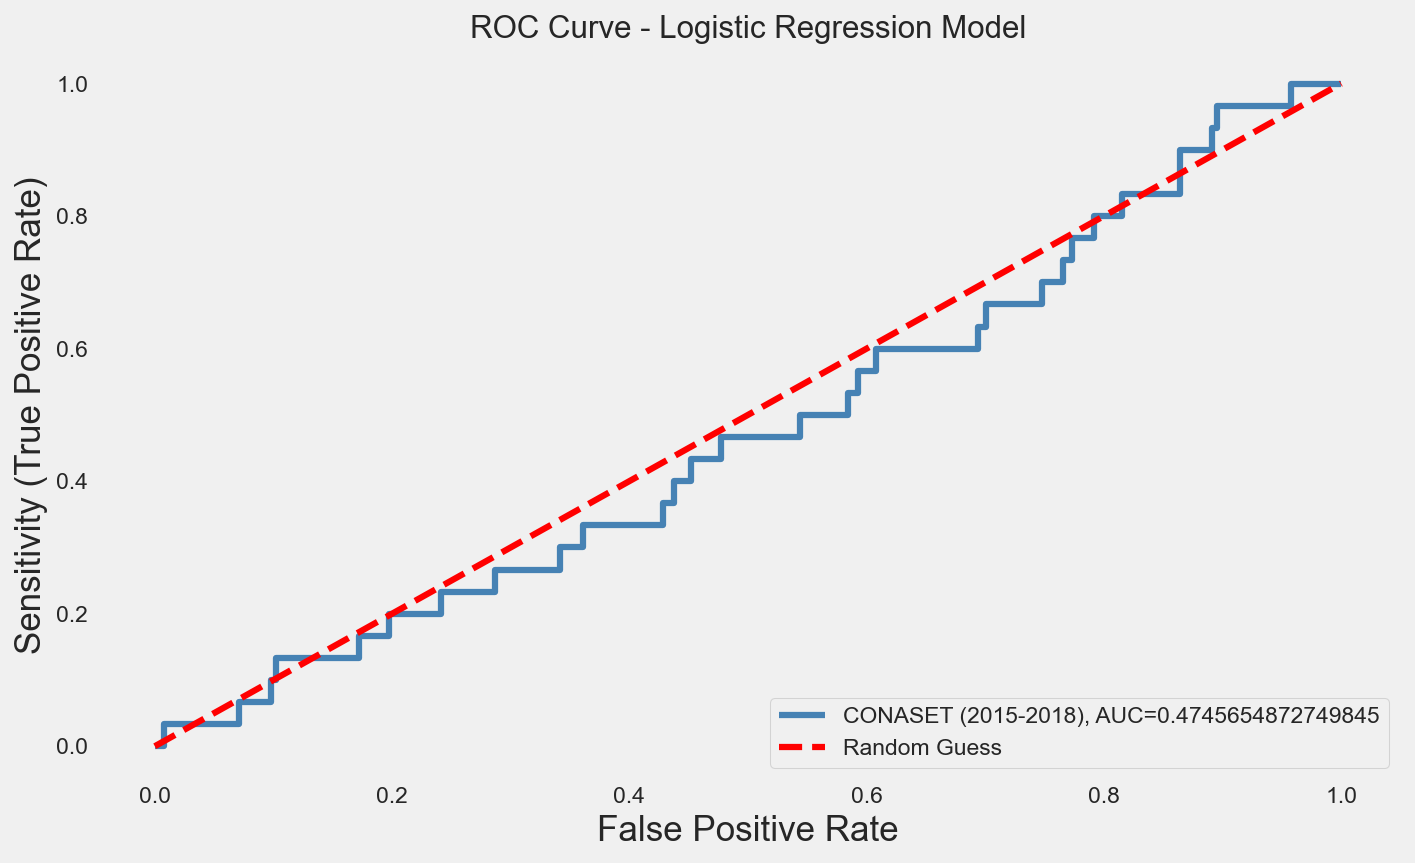

In [15]:
# import the metrics class
from sklearn import metrics
y_pred_proba = model_logreg.predict_proba(X_test)[::,1]
# display(y_pred_proba >= np.mean(y_pred_proba))
# temp = (np.median(y_pred_proba) + 2*np.std(y_pred_proba))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_logreg = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="CONASET (2015-2018), AUC="+str(auc_logreg),color='steelblue',lw=3)
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='red',lw=3,linestyle='dashed')
plt.grid()
plt.legend(loc=4)
plt.ylabel("Sensitivity (True Positive Rate)")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve - Logistic Regression Model", size = 15)
plt.show();

In [16]:
print(f"Train Accuracy: {model_logreg.score(X_train, y_train)}")
print(f"Test Accuracy:  {metrics.accuracy_score(y_test, y_pred)}")
print(f"AUC:            {auc_logreg}")

Train Accuracy: 0.9926782273603083
Test Accuracy:  0.9930651872399445
AUC:            0.4745654872749845


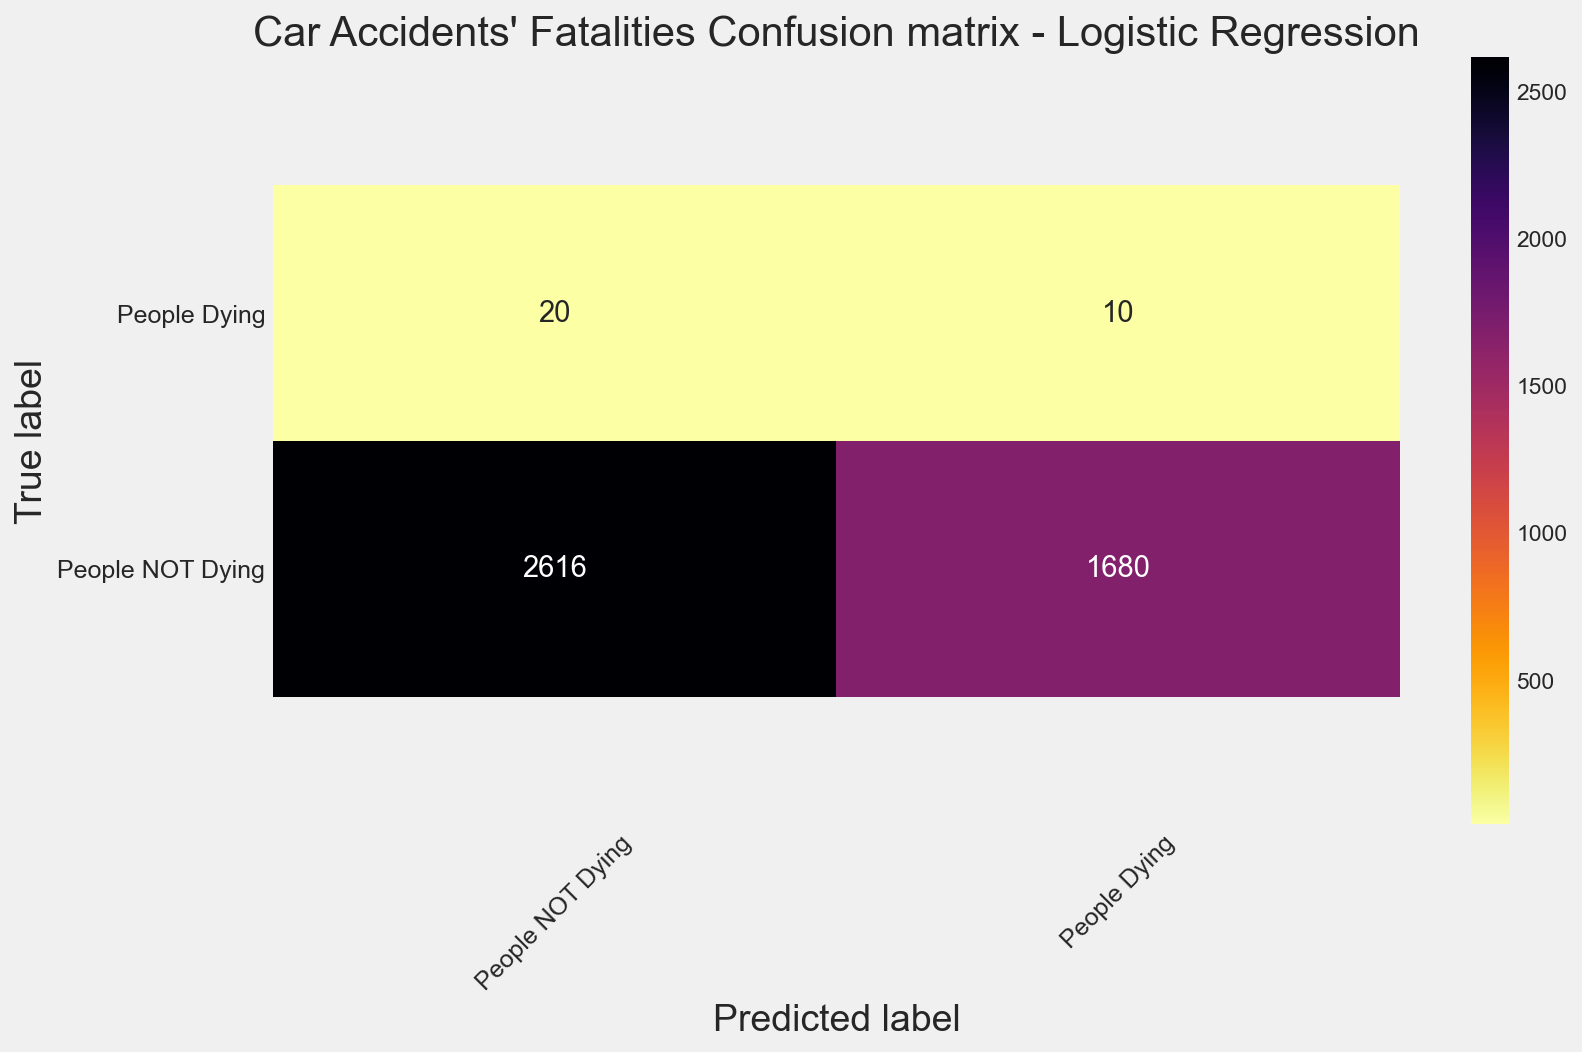

<Figure size 1200x300 with 0 Axes>

In [17]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_proba >= (np.median(y_pred_proba) +.3*np.std(y_pred_proba)))
# cnf_matrix
class_names=["People NOT Dying", "People Dying"] # name  of classes
fig, ax = plt.subplots()


# create heatmap
ax = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="inferno_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title("Car Accidents' Fatalities Confusion matrix - Logistic Regression", size = 20)
plt.tight_layout()
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, ["People NOT Dying", "People Dying"], rotation=45, size = 12)
plt.yticks(tick_marks, ["People NOT Dying", "People Dying"], size = 12, rotation = 0)
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
ax.set_ylim(-0.5,len(cnf_matrix)+0.5)
plt.figure(figsize=(8,2));

For our project, we will be also using a __Confusion Matrix__ to evaluate the Classification models. We use Confusion Matrix in Classificatiion problems because the output is a feature. It is a measurment in performance of our AUC of the ROC Curve.

We will be modifying the confusion matrix as what represents the most predictive values of the ROC Curve by changing their location with respect to the Standard Deviation.

The Matrix is composed by 4 main components:
- __True Positive (top right)__ : Predicted Positive and it's True
    - The model correctly labels that people died
    
    
- __False Positive (Error) (bottom right)__: Predicted Positive but it's False
    - Means that people that did not die are counted as dead
    
    
- __False Negative (Error) (top left)__: Predicted Negative but it's False
    - Means that people that died are counted as not dead
    
    
- __True Negative (bottom left)__: Predicted Negative and it's True
    - The model correctly label that people did not die

__Recall__: TP/(TP + FN) is the ability of the model to return all relevant instances. If we want to know whether or not people are dying. 

__Precission__: TP /(TP + FP) is the ability of the model to return only the corrected predicted or relevant instances.


Some important notes:
- Each category is a count. Not a probability.

- Confusion Matrices only work with positive classes - People dying is the Positive class and People NOT dying is Negative class.

- The threshold could be set to any value between 0 and 1. Every threshold results in a different confusion matrix and a number of thresholds will result in a large number of confusion matrices which is not the best way to work.

- ROC curve shows how the recall vs precision relationship changes as we vary the threshold for identifying a positive in our model.

### Understanding our Logistic Model

Our Logistic Regression Model is not capable of differentiating between features. This is a problem for our goal because we want a model that is strong enough to differentiate between features. However, during EDA we found some interesting aspects about our data. Above, it was shown that less than 1% of accidents recorded by the CONASET from 2015 to 2018 resulted in casualties of pedestrians or drivers. In other words, there exists a great difference in the number of people not dying and dying during accidents. 

According to [this article](https://www.edmunds.com/car-safety/are-smaller-cars-as-safe-as-large-cars.html), different sizes of cars might affect the safety of their passengers differently. We would like to know what were the car models that were involved in the accidents recorded. The article talks about the "Decade of Improvement in car safety". It shows the different fatality rates in 2005 and 2015 considering the size of the cars, SUVs, and Pickups. In a way this Logistic Regression shows the argument of the article is correct since over 99% of people that were encountered in car accidents as pedestrians or drivers did not suffer casualties.

Our Confusion Matrix also has some interesting results. We moved the threshold of our Confusion Matrix by .3 Standard Deviations above the median in order to get the highest peak as posible of the ROC Curve.

### Random Forest with one-hot encoding in the categorical features

Since the proportion of people dying and not dying in accidents does not favor us, __we will try to identify the most important features that the Chilean government and CONASET should look after in order to prevent higher number of accidents.__

Now we can move on to a more powerful model, the Random Forest. This takes the idea of a single Decision Tree, and creates an ensemble model out of hundreds or thousands of trees to reduce the variance.  We can define a Decision Tree as an interpretable model because it makes classifications much like we do: we ask a sequence of queries about the available data we have until we arrive at a decision. 

For this project, we will not be using Decision Trees by themselves, because of the low performance and high chance of running into overfitting. Instead, we will use a Random Forest Classifier.

In Random Forest each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

We will use the Random Forest model using one-hot encoding to turn the categorical features into numerical features.

Steps:
- We will use One-Hot Encoding using `pd.get_dummies`.
- Then we will import the necessary Random Forest object to use the model. `model_rf=RandomForestClassifier(n_estimators=100)` will build a forest of 100 Decision Trees.
- We will train our training datasets using `.fit()` so we can obtain optimized betas with `.predict()`.

Notes:
- We will exclude `Deaths Quantity` and `Death` features because `Death` is our target feature that we want to predict, which tell us whether or not in an accident there was a casuality/casualties (binary column of 1s and 0s) and `Deaths Quantity` is the amount of people that suffered casualties in an accidents. Although `Deaths Quantity` is not our target prediction feature, we think that it should be excluded from the regression because of the very close similarity with our target feature.

- The `geometry` is excluded because it contains `POINT` data type values that cannot be encoded. Recall that `geometry` gives the exact coordinate of each accident in the city of Santiago. In this project is used for the Geo representation of the Data.

In [18]:
feat_cols = [
   'Accident Type',
    'Atmospheric State',
    'Cause',
    'Date',
    'Deaths Quantity',
    'District', 
    'Hour',
    'Medium Injuries',
    'Minor Injuries', 
    'Serious Injuries', 
    'Road_Direction', 
    'Road_Type',
    'Street 1',
    'Street 2',
    'Weather',
    'Year',
    'Zone', 
#     'geometry', 
    'Month',
    'Day',
    'Week_of_Year',
    'Day Of Year',
    'Quarter', 
    'Season',
    'Death',
    'Holiday',
    'Month_Numeric', 
    'Day_Numeric'
]
num_binary_features = [ 'Date',
                       'Deaths Quantity',
                       'Hour',
                       'Medium Injuries',
                        'Minor Injuries', 
                        'Serious Injuries', 
                        'Year',
                        'Month',
                        'Day',
                        'Week_of_Year',
                        'Day Of Year',
                        'Quarter', 
                        'Season',
                        'Death',
                        'Holiday',
                        'Month_Numeric', 
                        'Day_Numeric'
]

categorical_features = ['Accident Type',
                         'Atmospheric State',
                         'Cause',
                        'District', 
                        'Road_Direction', 
                        'Road_Type','Street 1',
                        'Street 2',
                        'Weather',
                        'Zone'
                        ]

# One-hot encode
features = pd.get_dummies(conaset_df.drop(["Deaths Quantity", "geometry"], axis = 1))# Features

# Target are the values we want to predict
target = np.array(conaset_df["Death"]) # Target variable

# Remove the target from the features
features = features.drop("Death", axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to array
features = np.array(features)

In [19]:
#Let's train our model - 70% training and 30% test
from sklearn.model_selection import train_test_split

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(features, target, test_size=0.3) 

In [20]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model_rf=RandomForestClassifier(n_estimators=100, random_state=42)

In [21]:
#Train the model using the training sets y_pred or optimized beta
model_rf.fit(X_train_rf,y_train_rf)

RandomForestClassifier(random_state=42)

In [22]:
y_pred_rf=model_rf.predict(X_test_rf)

In [23]:
# Get numerical feature importances
importances = list(model_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [24]:
out = pd.Series(dict(feature_importances))

#### Visualization of Important Features

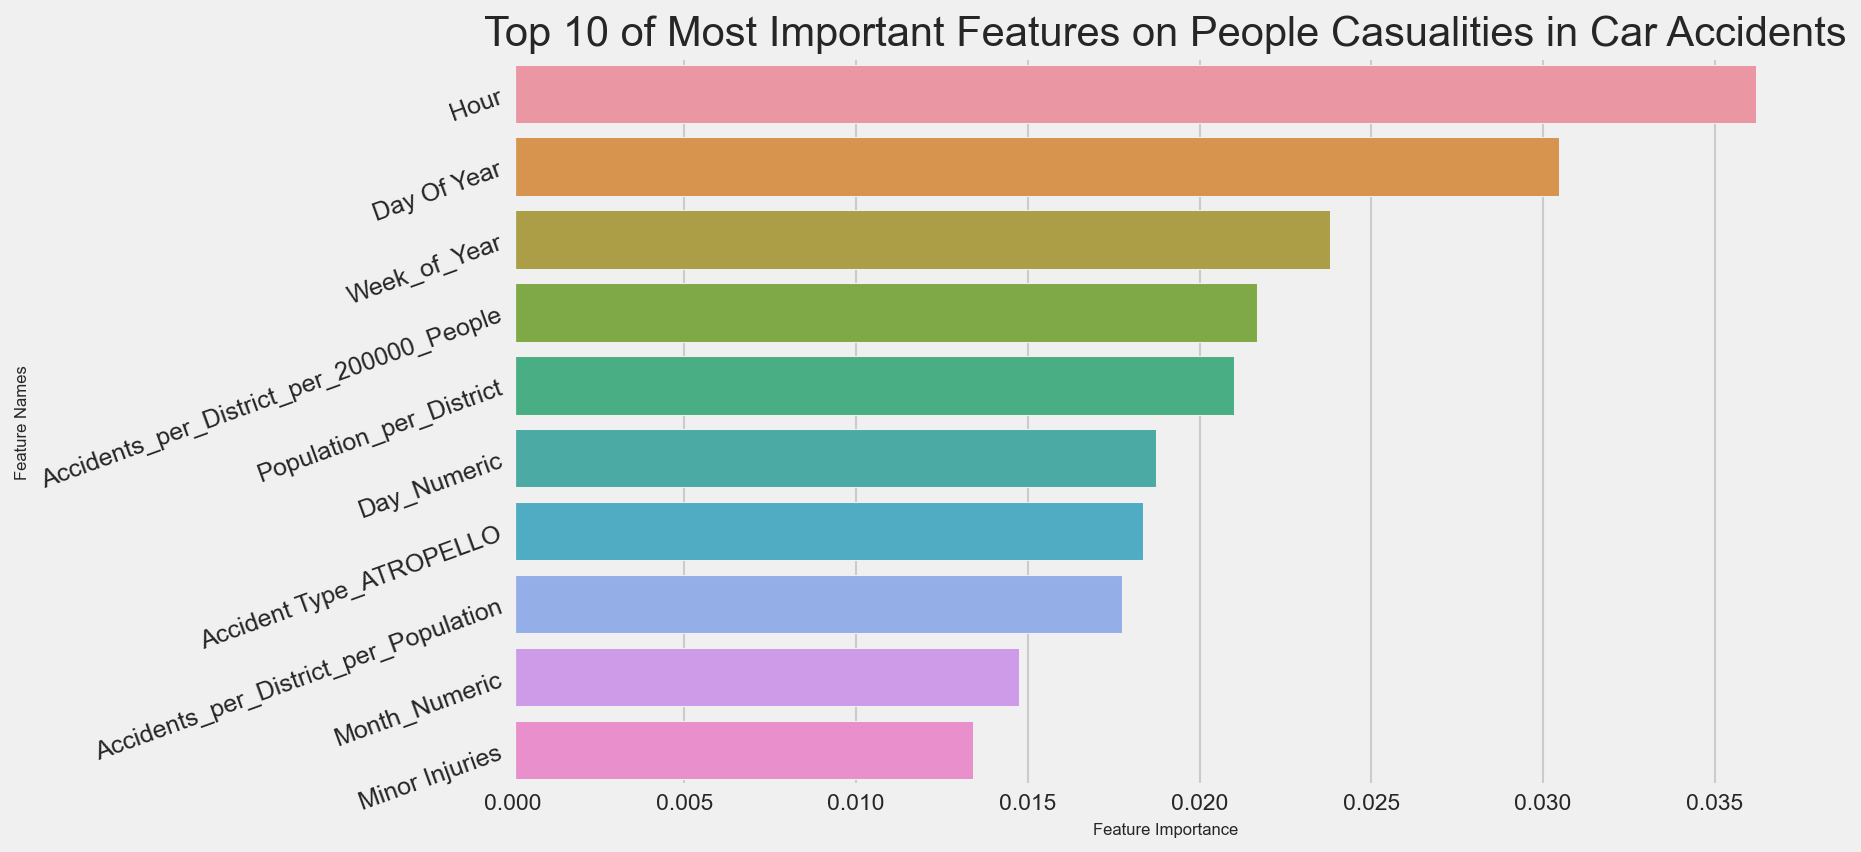

In [25]:
sns.barplot(x=out.values, y=out.index, order = out.index[:10])
plt.xlabel("Feature Importance", size = 8)
plt.ylabel("Feature Names", size = 8)
plt.yticks(rotation = 20, size=12)
plt.title("Top 10 of Most Important Features on People Casualities in Car Accidents", size = 20);

#### ROC Curve

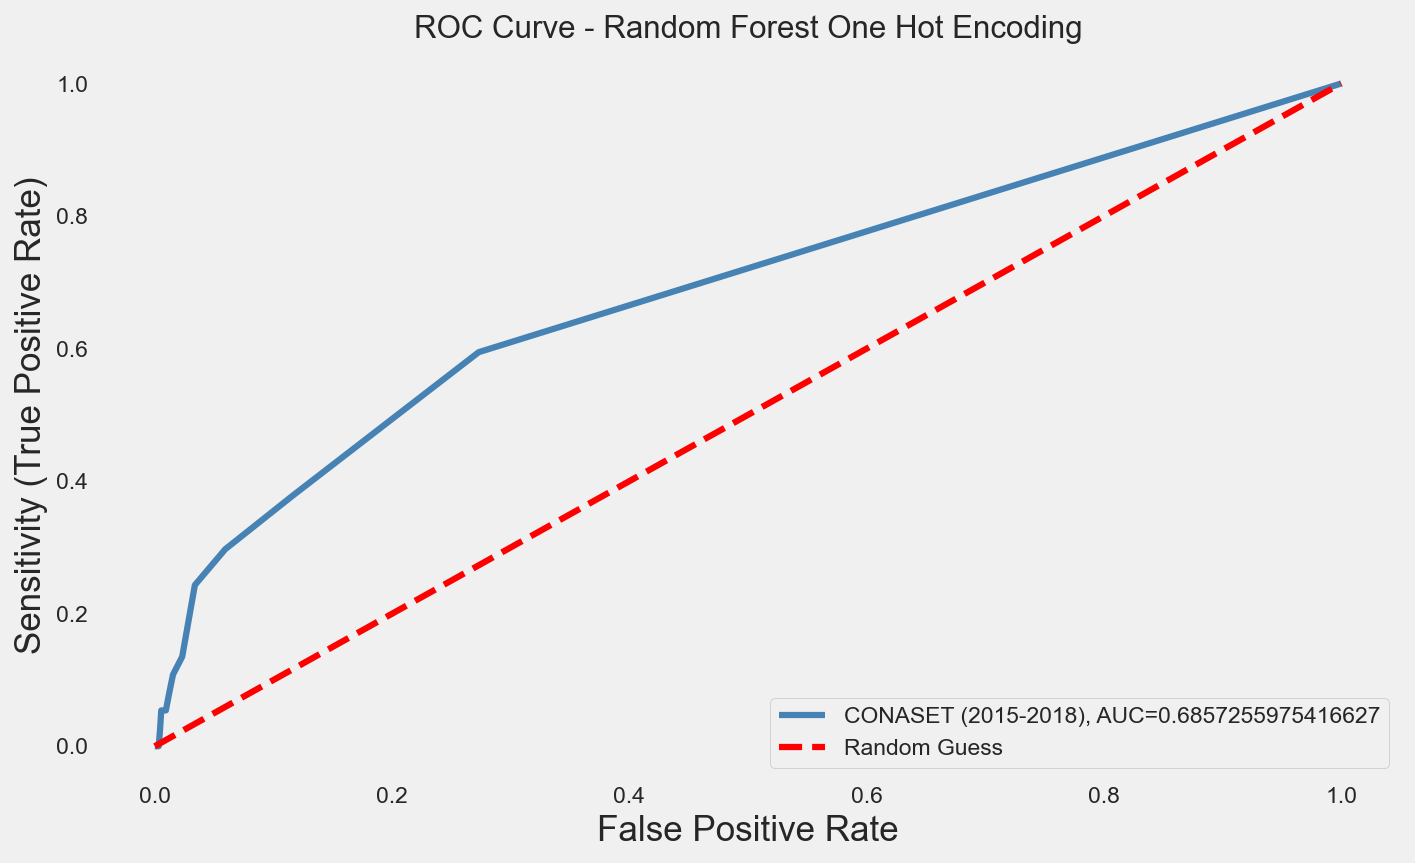

In [26]:
from sklearn import metrics
y_pred_proba_rf = model_rf.predict_proba(X_test_rf)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_rf,  y_pred_proba_rf)
auc_rf = metrics.roc_auc_score(y_test_rf, y_pred_proba_rf)
plt.plot(fpr,tpr,label="CONASET (2015-2018), AUC="+str(auc_rf),color='steelblue',lw=3)
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='red',lw=3,linestyle='dashed')
plt.legend(loc=4)
plt.grid()
plt.ylabel("Sensitivity (True Positive Rate)")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve - Random Forest One Hot Encoding", size = 15)
plt.show();

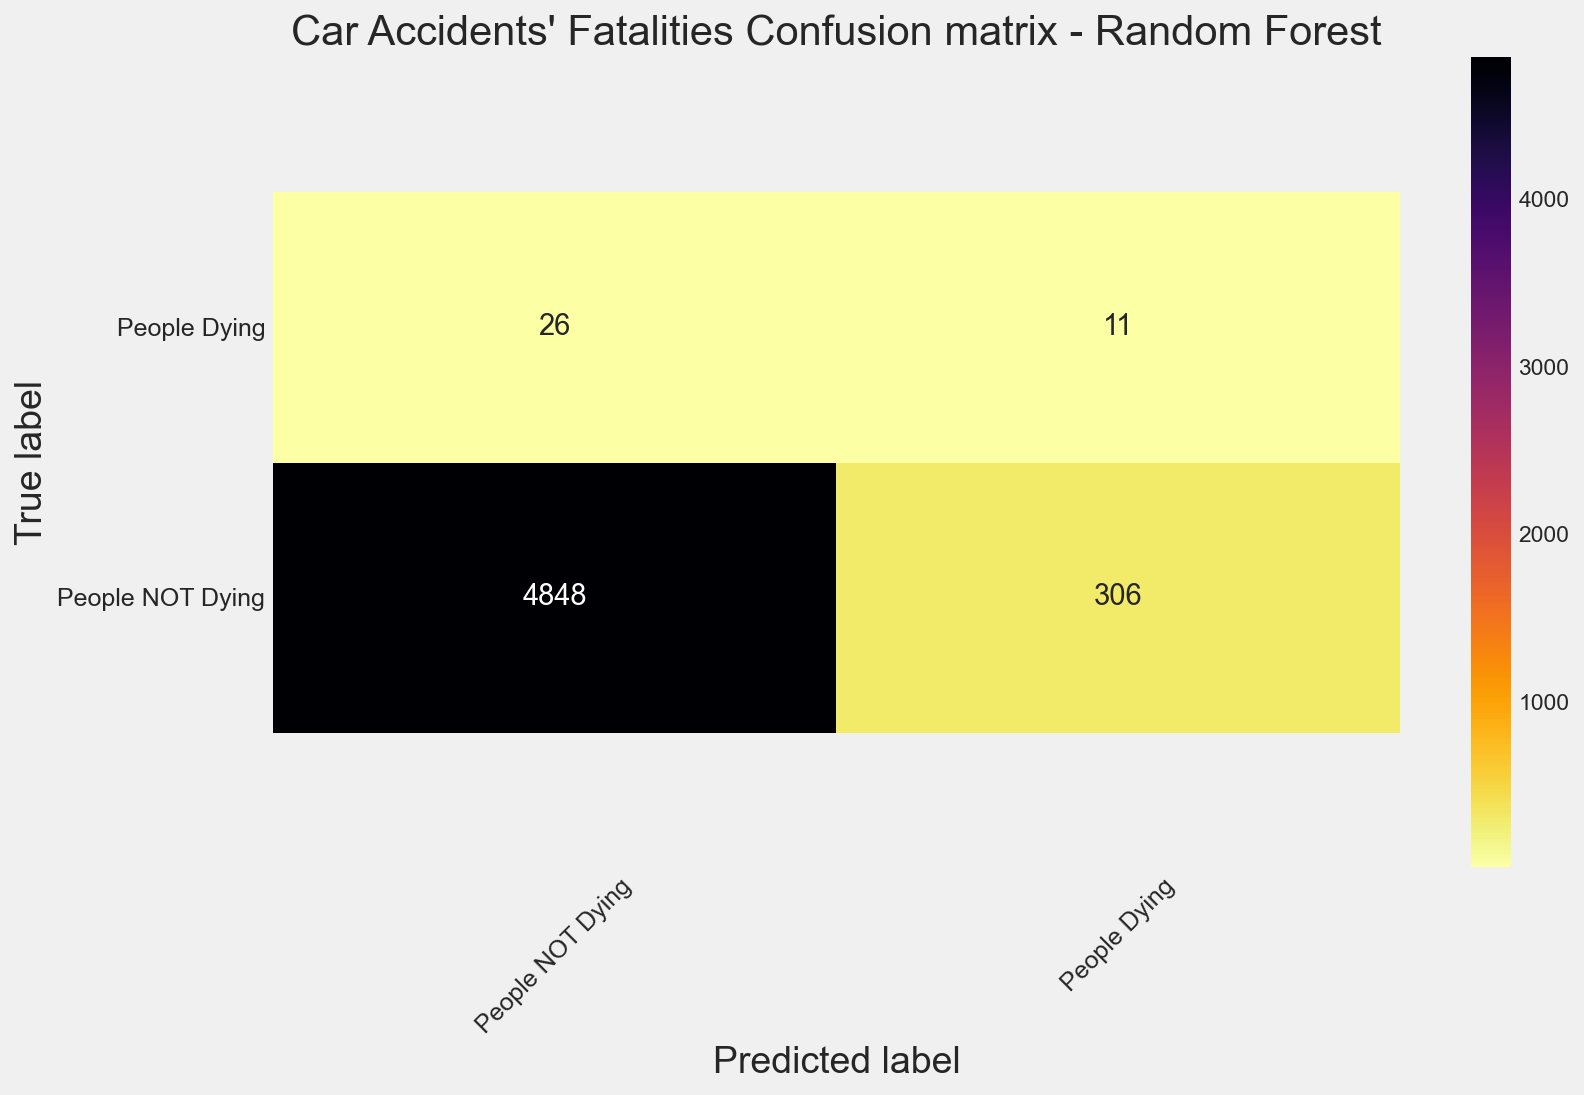

<Figure size 1200x300 with 0 Axes>

In [27]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_rf, y_pred_proba_rf >= (np.median(y_pred_proba_rf) + 2*np.std(y_pred_proba_rf)))
# cnf_matrix
class_names=["People NOT Dying", "People Dying"] # name  of classes
fig, ax = plt.subplots()


# create heatmap
ax = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="inferno_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title("Car Accidents' Fatalities Confusion matrix - Random Forest", size = 20)
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, ["People NOT Dying", "People Dying"], rotation=45, size = 12)
plt.yticks(tick_marks, ["People NOT Dying", "People Dying"], size = 12, rotation = 0)
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
ax.set_ylim(-0.5,len(cnf_matrix)+0.5)
plt.figure(figsize=(8,2));

- __True Positive (top right)__ : Predicted Positive and and it's True
    - the model correctly labels that people died
    
    
- __False Positive (Error) (bottom right)__: Predicted Positive but it's False
    - means that people did not die are counted as dead
    
    
- __False Negative (Error) (top left)__: Predicted Negative but it's False
    - means that people that died are counted as not dead
    
    
- __True Negative (bottom left)__: Predicted Negative and it's True
    - the model correctly label that people did not die

In [28]:
print(f"Train Accuracy:         {model_rf.score(X_train_rf, y_train_rf)}")
print(f"Test Accuracy:          {metrics.accuracy_score(y_test_rf, y_pred_rf)}")
print(f"Area Under the Curve:   {auc_rf}")

Train Accuracy:         0.9999174236168455
Test Accuracy:          0.9928722789443267
Area Under the Curve:   0.6857255975416627


### Understanding our Random Forest Model and Comparing with Logistic Regression using the ROC Curve

Although we still have very similar Training and Test Accuracies, we have been able to increase the power of predicting if people die or not in car accidents using this project data. Our Area of the Roc Curve has gone above 75% which compared to the Logistic regression of about 50% is predicting much better.

The reader should understand why we are using the ROC Curve as a measure of comparison between the models. When needed to visualize a comparison of a multi-class classification problem, we learned in Data 100 Fall 2019 that using a ROC Curve helps to understand the performance of a classification model and we can compare its performance to another classification model that is also using a ROC Curve.

The ROC Curve is a probability curve and AUC represents measure of separability among features. In other words, they tell how much the model is capable of distinguishing between features. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

In the first ROC Curve we saw an AUC of about 50%. This means that the model has no feature separation and using Logistic Regression it is really hard to differentiate between different features.

The Random Forest model has a AUC of about 75%, which means that there is a 75% chance that the Random Forest Model will be able to distinguish between the people that suffered casualties and the people that did not. In addition, we can extract from the `RandomForestClassifier` the most important features that help to predict our target such as, `Day Of Year`, `Week_of_Year`, and `Accidents_per_District_per_200000_People`.

The difference between the AUCs means that having a 50% AUC model has no capacity to distinguish when people die or not in accidents compared to a much powerful predictor model of the Random Forest model.

***

### Logistic Regression Using Pipeline

So far, we have seen a low performance in the Logistic Regression Model and a slightly better performance in the Random Forest. Turning our attention to how the Logisitc Regression model can be improved and let's see if the algorithm performs better when features are on a relatively similar scale and close to normally distributed. In Data 100 Fall 2019, we learned about different techniques on pre-processin the data prior modeling.

We learned about Scaling, Standarized, and Normalizing:
- Scaling is to change the range of values. In other words, we keep the proportions of the original values, but we make the values smaller.

- Standarizing  is to change the values so that the Standard Deviation of the values of a feature is close to the mean of the values of the features.

- Normalizing is to do either Scaling or Standarizing but by taking its mean or average.


We want to compare if performing these techniques can actually help features to arrive in a more digestable form for our models.

For this section of the project, we will use a preprocessing method from sklearn called `sklearn.preprocessing.StandardScaler`. It standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler does not meet the strict definition of scale.

We can use the idea of a Pipeline that glue together the `StandardScaler()` and our desired model in order to ensure that during the Cross Validation the `StandardScaler()` is fitted to only the training fold, just like we used for our `model.fit()`

We will apply one-hot encoding in all features.



In [29]:
# One-hot encode
features = pd.get_dummies(conaset_df.drop(["Deaths Quantity", "geometry"], axis = 1))# Features

# Target are the values we want to predict
target = np.array(conaset_df["Death"]) # Target variable

# Remove the target from the features
features = features.drop("Death", axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to array
features = np.array(features)

In [30]:
X_train_logreg_cv, X_test_logreg_cv, y_train_logreg_cv, y_test_logreg_cv = train_test_split(features, target, test_size = 0.25, random_state = 42)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# scale = StandardScaler().fit(X_test_logreg_cv)
# X_train_scaled = scale.transform(X_train_logreg_cv)


pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', LogisticRegression(max_iter = 1000))
])

# use the pipeline object as you would
# a regular classifier
pipeline.fit(X_train_logreg_cv,y_train_logreg_cv)

y_pred_logreg_cv = pipeline.predict(X_test_logreg_cv)

#### ROC Curve

array([False, False, False, ..., False, False, False])

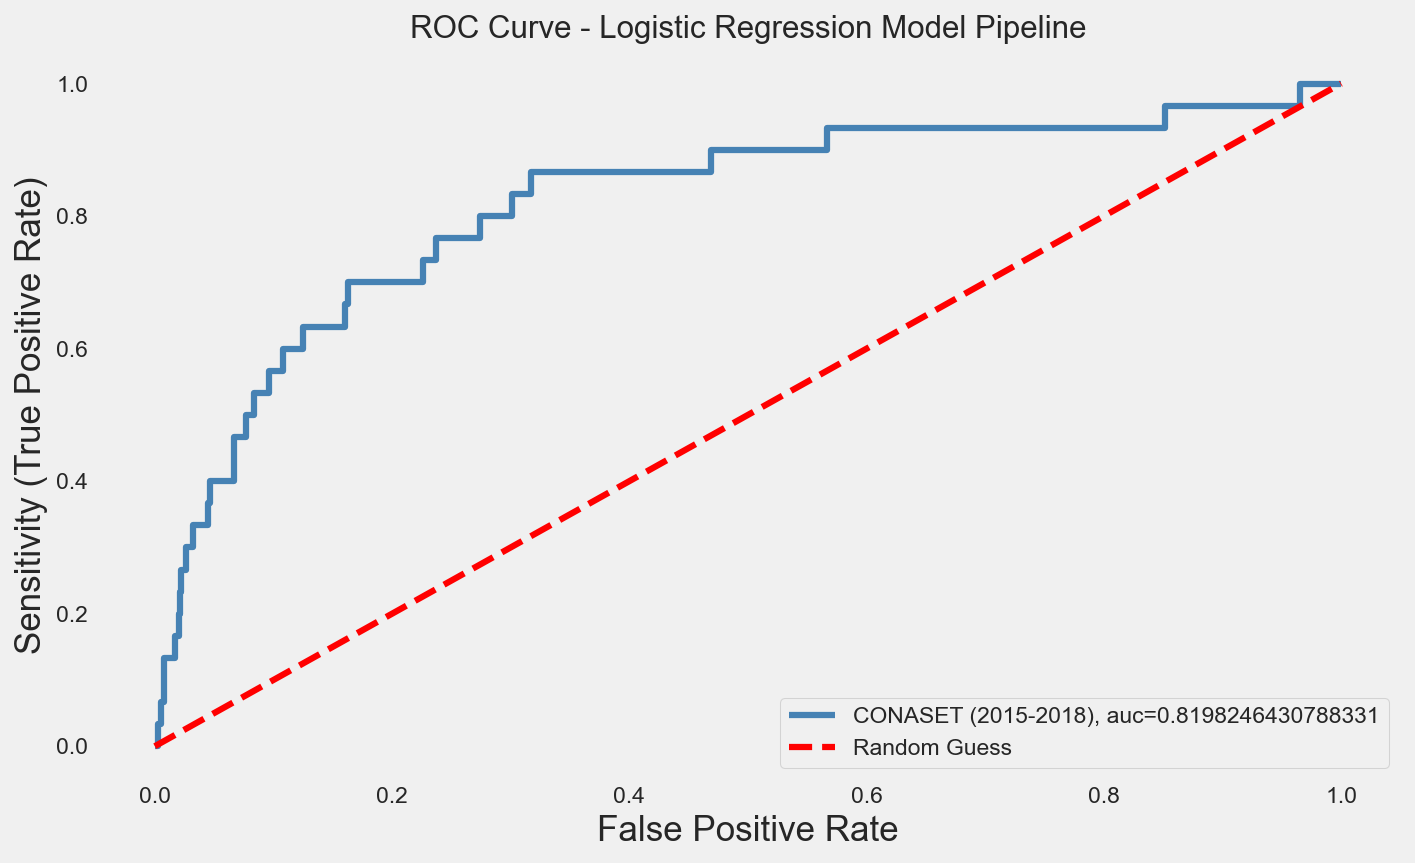

In [32]:
# import the metrics class
from sklearn import metrics
y_pred_proba = pipeline.predict_proba(X_test_logreg_cv)[::,1]
display(y_pred_proba >= np.mean(y_pred_proba))
# temp = (np.median(y_pred_proba) + 2*np.std(y_pred_proba))
fpr, tpr, _ = metrics.roc_curve(y_test_logreg_cv,  y_pred_proba)
auc_logreg_cv = metrics.roc_auc_score(y_test_logreg_cv, y_pred_proba)
plt.plot(fpr,tpr,label="CONASET (2015-2018), auc="+str(auc_logreg_cv),color='steelblue',lw=3)
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='red',lw=3 ,linestyle='dashed')
plt.grid()
plt.legend(loc=4)
plt.ylabel("Sensitivity (True Positive Rate)")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve - Logistic Regression Model Pipeline", size = 15)
plt.show();

In [33]:
print(f"Train Accuracy: {pipeline.score(X_train_logreg_cv, y_train_logreg_cv)}")
print(f"Test Accuracy:  {metrics.accuracy_score(y_test_logreg_cv, y_pred_logreg_cv)}")
print(f"AUC:            {auc_logreg_cv}")

Train Accuracy: 1.0
Test Accuracy:  0.9905224225612576
AUC:            0.8198246430788331


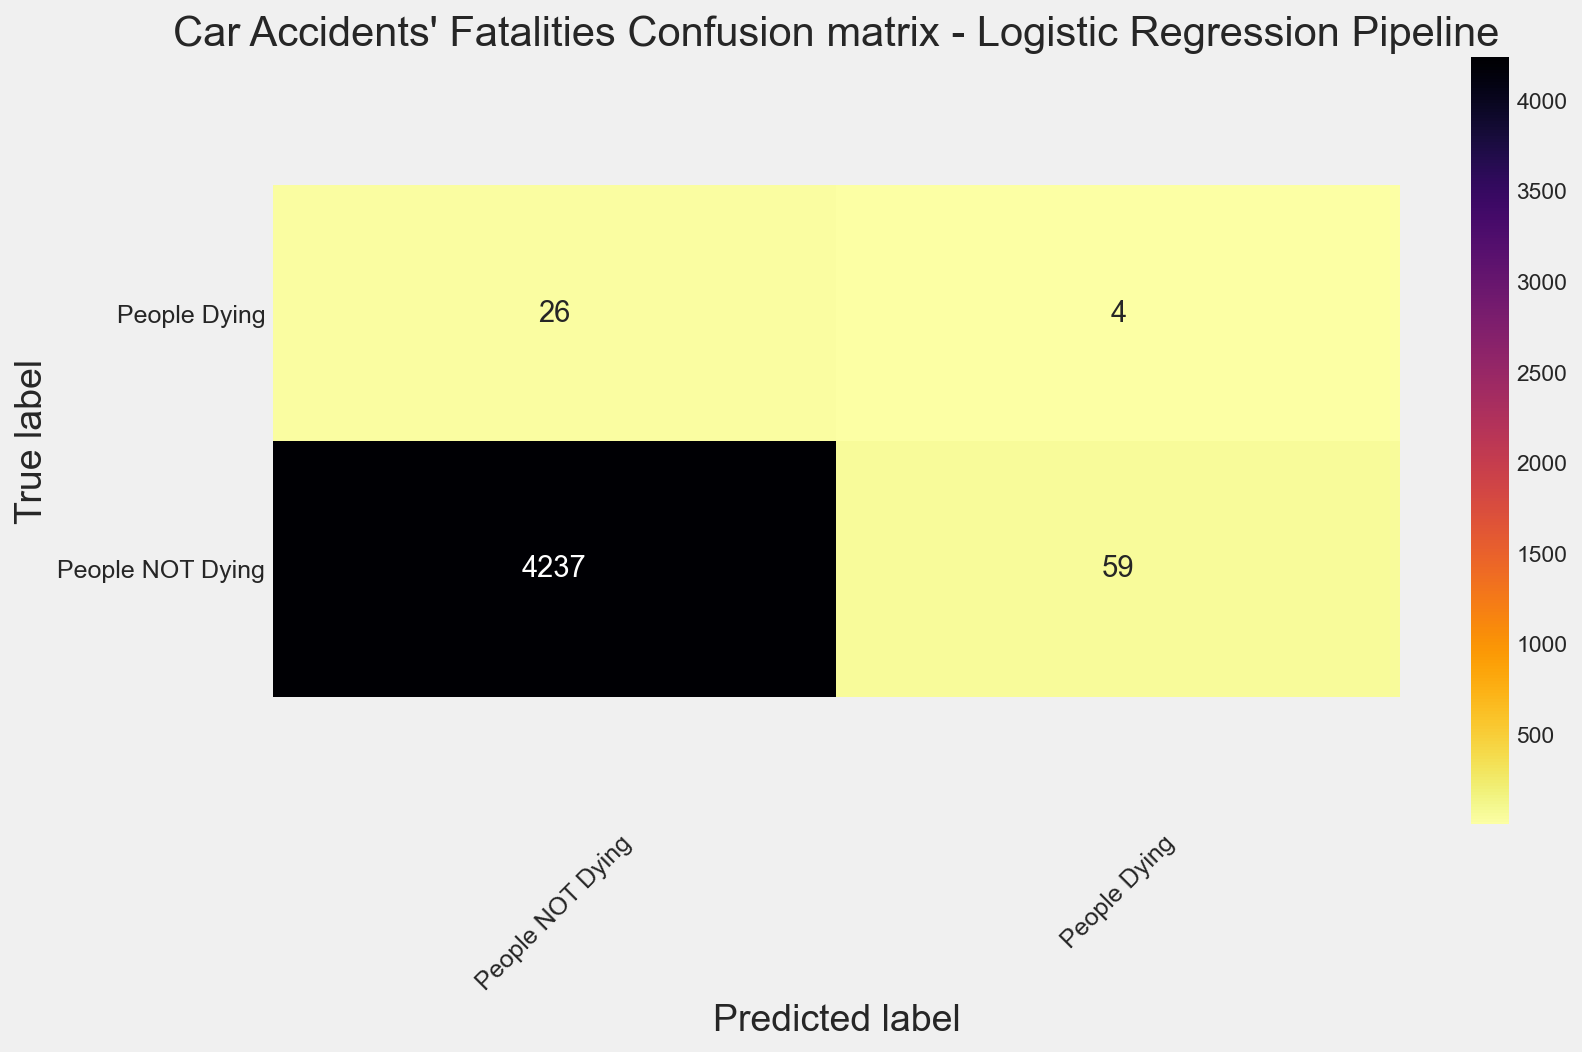

<Figure size 1200x300 with 0 Axes>

In [34]:
cnf_matrix = metrics.confusion_matrix(y_test_logreg_cv, y_pred_proba >= (np.median(y_pred_proba) +.3*np.std(y_pred_proba)))
# cnf_matrix
class_names=["People NOT Dying", "People Dying"] # name  of classes
fig, ax = plt.subplots()


# create heatmap
ax = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="inferno_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title("Car Accidents' Fatalities Confusion matrix - Logistic Regression Pipeline", size = 20)
plt.tight_layout()
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, ["People NOT Dying", "People Dying"], rotation=45, size = 12)
plt.yticks(tick_marks, ["People NOT Dying", "People Dying"], size = 12, rotation = 0)
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
ax.set_ylim(-0.5,len(cnf_matrix)+0.5)
plt.figure(figsize=(8,2));

For our project, we will be also using a __Confusion Matrix__ to evaluate the Classification models. We use Confusion Matrix in Classificatiion problems because the output it is a feature. It is a measurment in performance of our AUC of the ROC Curve.

The Matrix is composed by 4 main components:
- __True Positive (top right)__ : Predicted Positive and and it's True
    - the model correctly labels that people died
    
    
- __False Positive (Error) (bottom right)__: Predicted Positive but it's False
    - means that people did not die are counted as dead
    
    
- __False Negative (Error) (top left)__: Predicted Negative but it's False
    - means that people that died are counted as not dead
    
    
- __True Negative (bottom left)__: Predicted Negative and it's True
    - the model correctly label that people did not die

### Understanding the new Logistic Regression

We have a much better performance compared to the first Logistic Regression. Compared to Random Forest our Logistic regression + Pipeline does not do as well. However, these results are okay since we already have discussed the problem of having a really high number of people not dying. In other words, Logistic Regression is not a suitable model to use in a case such as this one.

***

### Random Forest with Pipeline 

In [35]:
feat_cols = [
   'Accident Type',
    'Atmospheric State',
    'Cause',
    'Date',
    'Deaths Quantity',
    'District', 
    'Hour',
    'Medium Injuries',
    'Minor Injuries', 
    'Serious Injuries', 
    'Road_Direction', 
    'Road_Type',
    'Street 1',
    'Street 2',
    'Weather',
    'Year',
    'Zone', 
#     'geometry', 
    'Month',
    'Day',
    'Week_of_Year',
    'Day Of Year',
    'Quarter', 
    'Season',
    'Death',
    'Holiday',
    'Month_Numeric', 
    'Day_Numeric'
]
num_binary_features = [ 'Date',
                       'Deaths Quantity',
                       'Hour',
                       'Medium Injuries',
                        'Minor Injuries', 
                        'Serious Injuries', 
                        'Year',
                        'Month',
                        'Day',
                        'Week_of_Year',
                        'Day Of Year',
                        'Quarter', 
                        'Season',
                        'Death',
                        'Holiday',
                        'Month_Numeric', 
                        'Day_Numeric'
]

categorical_features = ['Accident Type',
                         'Atmospheric State',
                         'Cause',
                        'District', 
                        'Road_Direction', 
                        'Road_Type','Street 1',
                        'Street 2',
                        'Weather',
                        'Zone'
                        ]

# One-hot encode
features = pd.get_dummies(conaset_df.drop(["Deaths Quantity", "geometry"], axis = 1))# Features

# Target are the values we want to predict
target = np.array(conaset_df["Death"]) # Target variable

# Remove the target from the features
features = features.drop("Death", axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to array
features = np.array(features)

In [36]:
#Let's train our model - 70% training and 30% test
from sklearn.model_selection import train_test_split

X_train_rf_pipe, X_test_rf_pipe, y_train_rf_pipe, y_test_rf_pipe = train_test_split(features, target, test_size=0.3) 


In [37]:


# scale = StandardScaler().fit(X_test_logreg_cv)
# X_train_scaled = scale.transform(X_train_logreg_cv)


pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# use the pipeline object as you would
# a regular classifier
pipeline.fit(X_train_rf_pipe,y_train_rf_pipe)

y_pred_rf_pipe = pipeline.predict(X_test_rf_pipe)

In [38]:
out = pd.Series(dict(feature_importances))

#### Visualization of Important Features

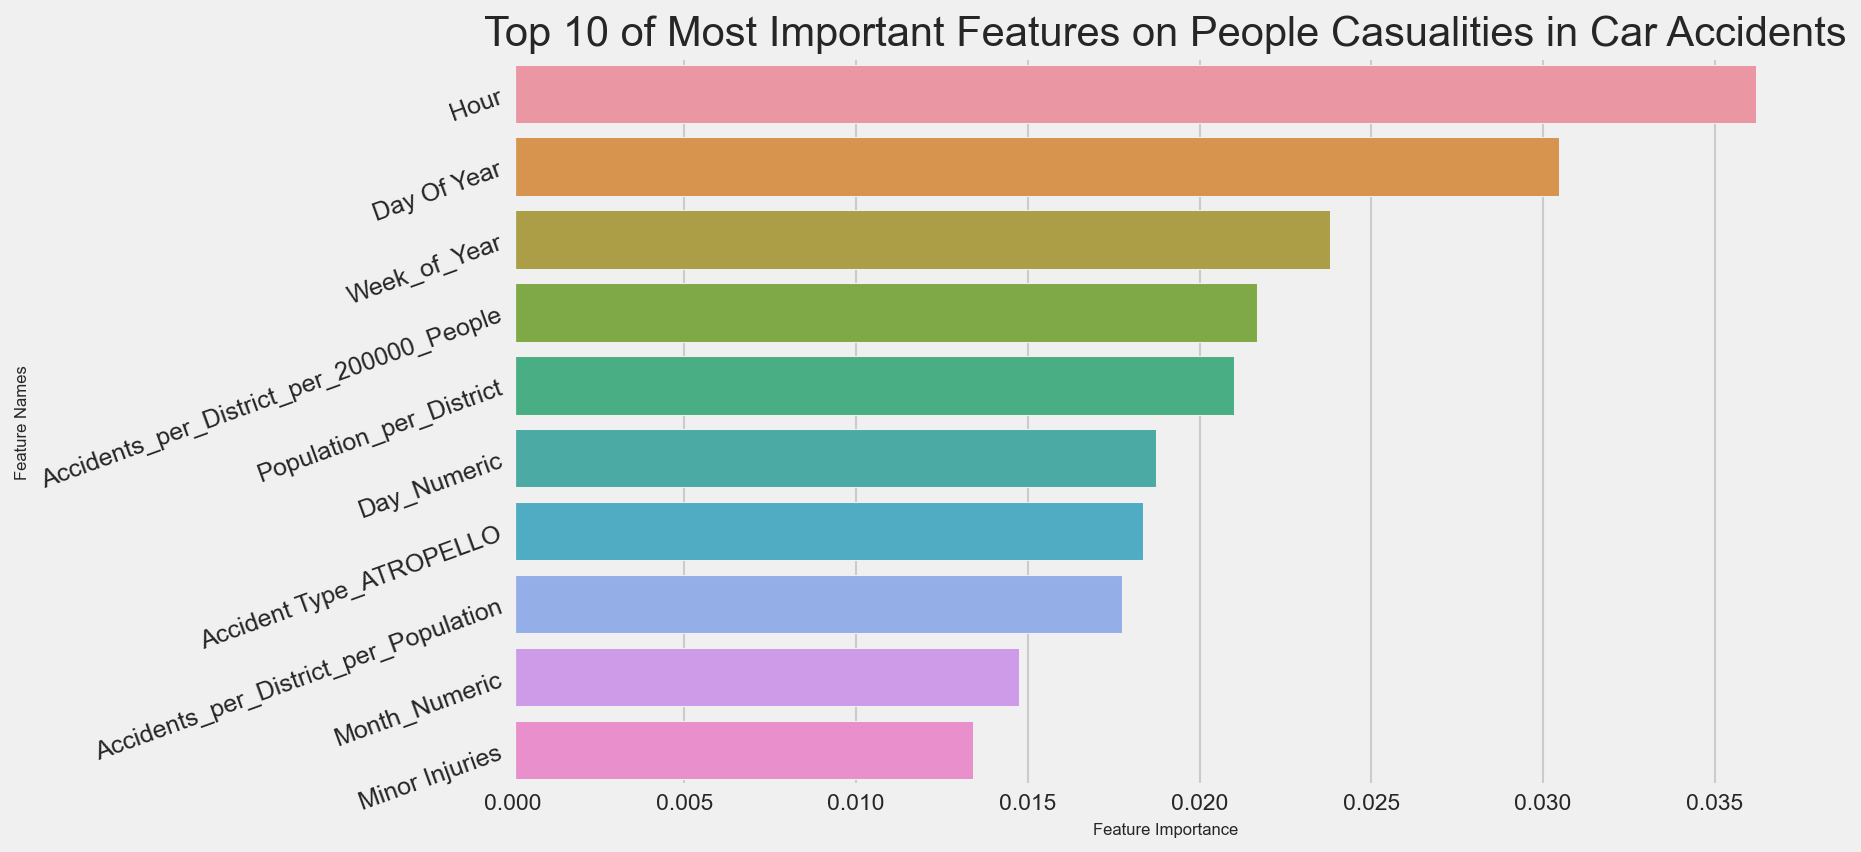

In [39]:
sns.barplot(x=out.values, y=out.index, order = out.index[:10])
plt.xlabel("Feature Importance", size = 8)
plt.ylabel("Feature Names", size = 8)
plt.yticks(rotation = 20, size=12)
plt.title("Top 10 of Most Important Features on People Casualities in Car Accidents", size = 20);

#### ROC Curve

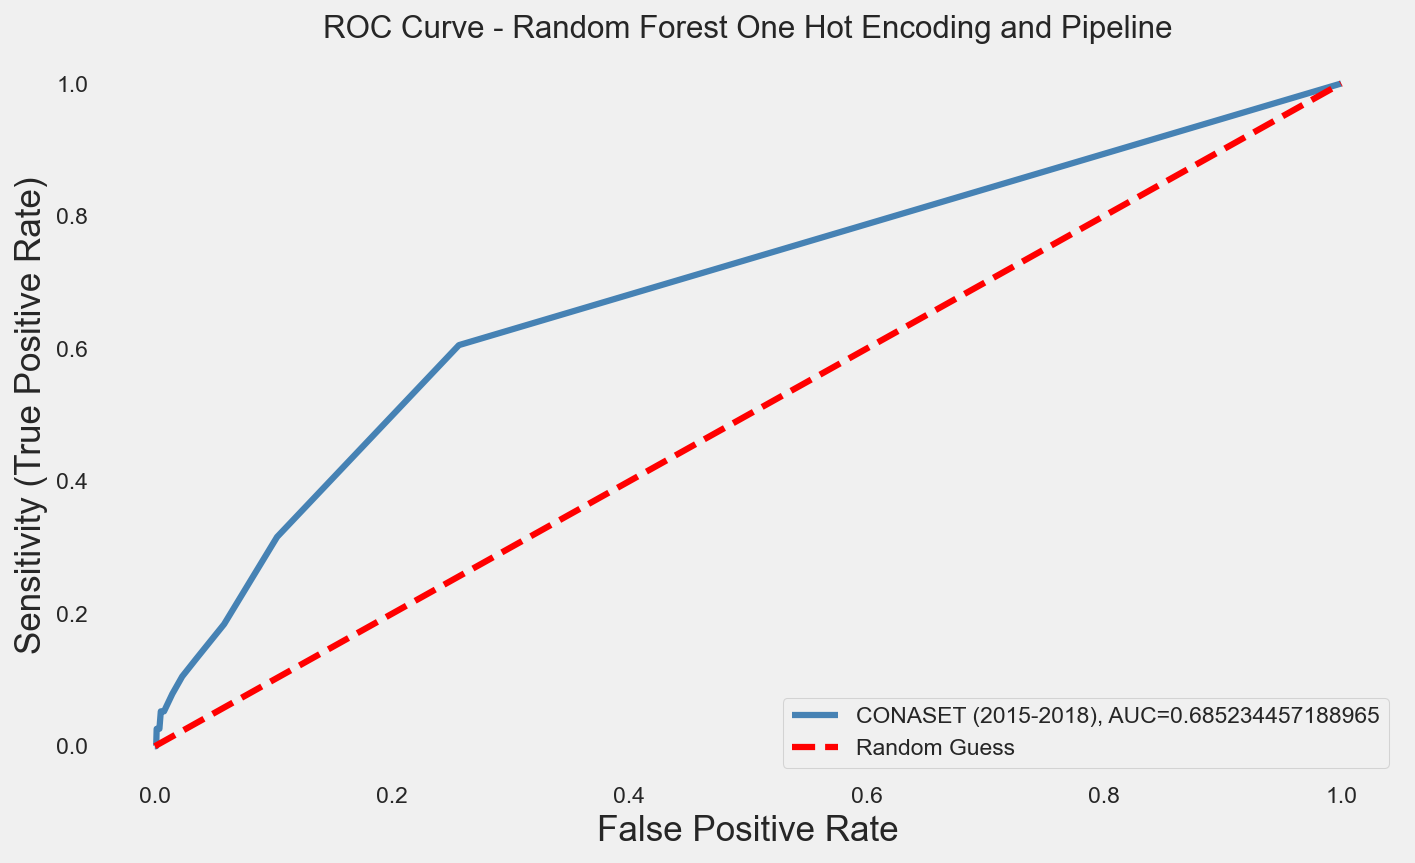

In [40]:
from sklearn import metrics
y_pred_proba_rf_pipe = pipeline.predict_proba(X_test_rf_pipe)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_rf_pipe,  y_pred_proba_rf_pipe)
auc_rf = metrics.roc_auc_score(y_test_rf_pipe, y_pred_proba_rf_pipe)
plt.plot(fpr,tpr,label="CONASET (2015-2018), AUC="+str(auc_rf),color='steelblue',lw=3)
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='red',lw=3,linestyle='dashed')
plt.legend(loc=4)
plt.grid()
plt.ylabel("Sensitivity (True Positive Rate)")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve - Random Forest One Hot Encoding and Pipeline", size = 15)
plt.show();

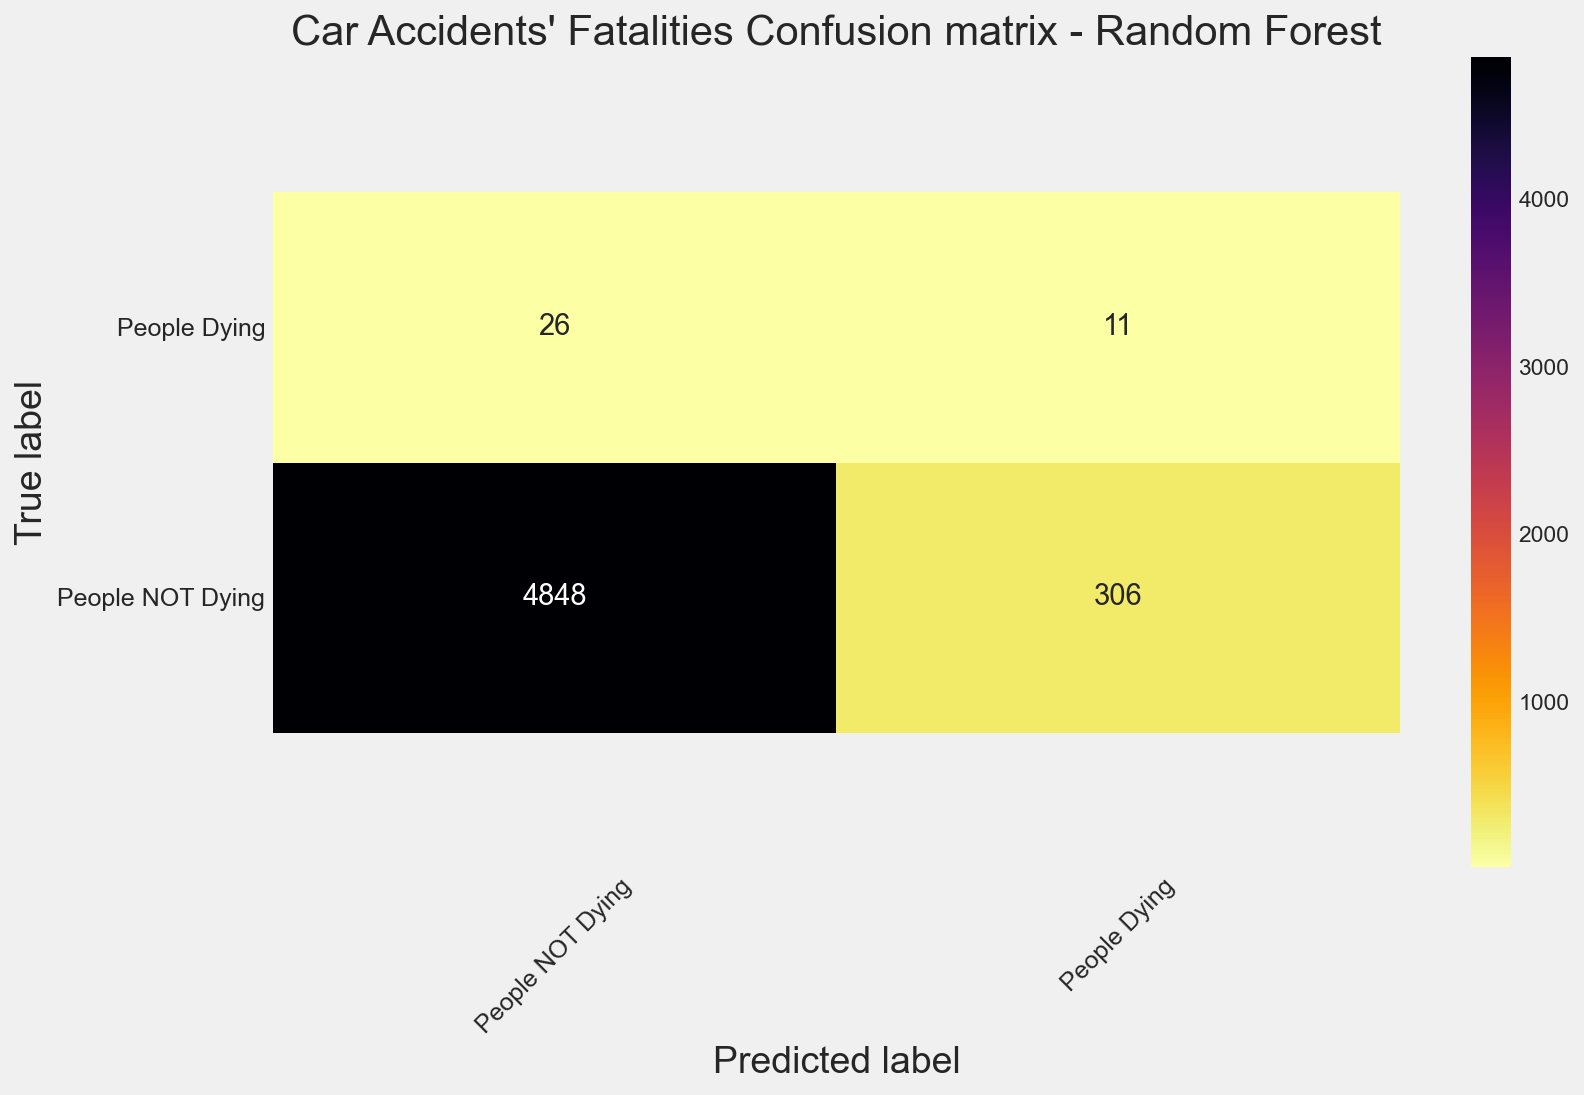

<Figure size 1200x300 with 0 Axes>

In [41]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_rf, y_pred_proba_rf >= (np.median(y_pred_proba_rf) + 2*np.std(y_pred_proba_rf)))
# cnf_matrix
class_names=["People NOT Dying", "People Dying"] # name  of classes
fig, ax = plt.subplots()


# create heatmap
ax = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="inferno_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title("Car Accidents' Fatalities Confusion matrix - Random Forest", size = 20)
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, ["People NOT Dying", "People Dying"], rotation=45, size = 12)
plt.yticks(tick_marks, ["People NOT Dying", "People Dying"], size = 12, rotation = 0)
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)
ax.set_ylim(-0.5,len(cnf_matrix)+0.5)
plt.figure(figsize=(8,2));

- __True Positive (top right)__ : Predicted Positive and and it's True
    - the model correctly labels that people died
    
    
- __False Positive (Error) (bottom right)__: Predicted Positive but it's False
    - means that people did not die are counted as dead
    
    
- __False Negative (Error) (top left)__: Predicted Negative but it's False
    - means that people that died are counted as not dead
    
    
- __True Negative (bottom left)__: Predicted Negative and it's True
    - the model correctly label that people did not die

In [42]:
print(f"Train Accuracy:         {model_rf.score(X_train_rf, y_train_rf)}")
print(f"Test Accuracy:          {metrics.accuracy_score(y_test_rf, y_pred_rf)}")
print(f"Area Under the Curve:   {auc_rf}")

Train Accuracy:         0.9999174236168455
Test Accuracy:          0.9928722789443267
Area Under the Curve:   0.685234457188965


***

## Conclusion and Future Work

We have identified important features that help us predict when people are losing their lives in car accidents. We also have found that we can actually make our models perfom better using `Pipeline` objects and `StandardScaler`.

Things that we would have wished to obtain from the original dataset:
- more specified information about the type of roads, causes of accidents because they were either not descriptive enough or some descriptions had too many random descriptions.
- more information about the context of the accident such as speed of wind, speed of when the cars collide, and temperature of the enviroment, etc.
- in the case of people under the influence of alcohol or drugs it would have been benefitial for us to have that data and see if we could feature engineering it.
- have a more consistent dataset throughout the year. Due to this lack of consistent datasets we had to drop many features from older datasets (2015, 2016) because of the lack of proper compilation.
- have full access to the truthfulness of the data. During this project we found that some data was suspect, such as when there were no accidents reported by the government during the last week of each year (See Heat Maps from EDA Jupyter Notebook).

__Future Work__:
- tune Hyperparameters of Models. Maybe use a `GridSearchCV` that exhaustively looks for each of the different parameter combinations in order to pick the best hyperparameters for the model or manually compare test vs training ROC Curve AUC performance to see when the dataset starts declining its performance.
- use a _Poisson Regression Model_ because of the great variation of values in our target variable. In other words, for cases like our project where only a few people (less than 1%) are losing their lives when they engange in an accident and the great majority are not, Logistic Regression does not work effectively here and Poisson Regression has _Rare Events_ that provides a better insight than Logistic Regression and might work better.
- obtain data of car models, year, etc to improve our feature engineering. 

With current results

- We have a somewhat accurate prediction model with our Random Forest that is backed up by the improved version of the Logistic Model. Extracting the most features from the Random Forest can give us hints as to where and when we can approach solid policies in order to prevent deathly car involved accidents. In this way, government and citizens can be fully informed when advocating for future policies and regulations to improve everybody's safety. Test